# Dataset

Dataset: https://www.kaggle.com/datasets/fernandol/countries-of-the-world

Dataset contains 227 rows (countries) and 20 feature, each feature represents a different aspect or measure of the specific country.

The goal of the project is predict GDP per capita for each country.

# Import Libraries and Data File

In [6]:
import warnings
import numpy as np
import joblib as jl
import pandas as pd
import seaborn as sns
import missingno as mn
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, RandomizedSearchCV

from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

In [7]:
data = pd.read_csv("countries_of_the_world.csv")

# Dataset Description

In [8]:
data.head()

,Country,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Country                             227 non-null    object 
 1   Region                              227 non-null    object 
 2   Population                          227 non-null    int64  
 3   Area (sq. mi.)                      227 non-null    int64  
 4   Pop. Density (per sq. mi.)          227 non-null    object 
 5   Coastline (coast/area ratio)        227 non-null    object 
 6   Net migration                       224 non-null    object 
 7   Infant mortality (per 1000 births)  224 non-null    object 
 8   GDP ($ per capita)                  226 non-null    float64
 9   Literacy (%)                        209 non-null    object 
 10  Phones (per 1000)                   223 non-null    object 
 11  Arable (%)                          225 non-n

Rename columns because it has spaces and special characters.

In [10]:
data.columns = (["country", "region", "population", "area", "density", "coastline", "migration", "infant_mortality", "gdp", "literacy", "phones", "arable",
                 "crops", "other", "climate", "birthrate", "deathrate", "agriculture", "industry", "service"])

Now, let's fix columns data types. Some columns has *object* data type but they need to be *float* or *category*.

In [11]:
data.country = data.country.astype("category")

data.region = data.region.str.strip()
data.region = data.region.astype("category")

for column in data.select_dtypes(include= "object").columns:
  data[column] = data[column].astype(str)
  data[column] = data[column].str.replace(",", ".").astype(float)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   country           227 non-null    category
 1   region            227 non-null    category
 2   population        227 non-null    int64   
 3   area              227 non-null    int64   
 4   density           227 non-null    float64 
 5   coastline         227 non-null    float64 
 6   migration         224 non-null    float64 
 7   infant_mortality  224 non-null    float64 
 8   gdp               226 non-null    float64 
 9   literacy          209 non-null    float64 
 10  phones            223 non-null    float64 
 11  arable            225 non-null    float64 
 12  crops             225 non-null    float64 
 13  other             225 non-null    float64 
 14  climate           205 non-null    float64 
 15  birthrate         224 non-null    float64 
 16  deathrate         223 non-

In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
population,227.0,2.874028e+07,1.178913e+08,7026.000,437624.00000,4786994.000,1.749777e+07,1.313974e+09
area,227.0,5.982270e+05,1.790282e+06,2.000,4647.50000,86600.000,4.418110e+05,1.707520e+07
density,227.0,3.790471e+02,1.660186e+03,0.000,29.15000,78.800,1.901500e+02,1.627150e+04
coastline,227.0,2.116533e+01,7.228686e+01,0.000,0.10000,0.730,1.034500e+01,8.706600e+02
migration,224.0,3.812500e-02,4.889269e+00,-20.990,-0.92750,0.000,9.975000e-01,2.306000e+01
infant_mortality,224.0,3.550696e+01,3.538990e+01,2.290,8.15000,21.000,5.570500e+01,1.911900e+02
gdp,226.0,9.689823e+03,1.004914e+04,500.000,1900.00000,5550.000,1.570000e+04,5.510000e+04
literacy,209.0,8.283828e+01,1.972217e+01,17.600,70.60000,92.500,9.800000e+01,1.000000e+02
phones,223.0,2.360614e+02,2.279918e+02,0.200,37.80000,176.200,3.896500e+02,1.035600e+03
arable,225.0,1.379711e+01,1.304040e+01,0.000,3.22000,10.420,2.000000e+01,6.211000e+01


 # **Missing Value Examination**

We can see that there is not lots of missing value in our dataset. Maximum percentage of missing data is in the *Climate* cloumn, and it is 9.69%.

We will handle these missing values later on.

<AxesSubplot:>

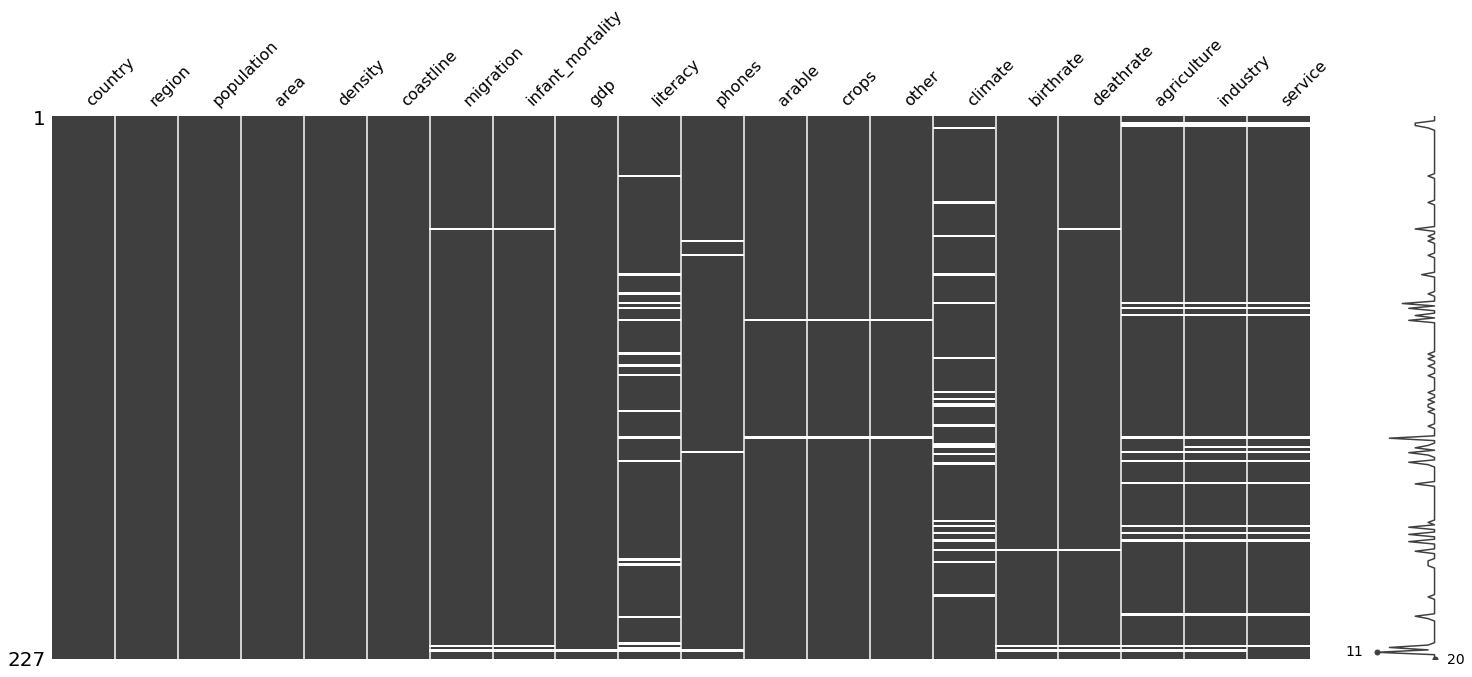

In [14]:
mn.matrix(data)

In [15]:
data.isnull().sum()

country              0
region               0
population           0
area                 0
density              0
coastline            0
migration            3
infant_mortality     3
gdp                  1
literacy            18
phones               4
arable               2
crops                2
other                2
climate             22
birthrate            3
deathrate            4
agriculture         15
industry            16
service             15
dtype: int64

Percentage of missing data in each column.

In [16]:
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})
print(missing_value_df)

                  percent_missing
country                  0.000000
region                   0.000000
population               0.000000
area                     0.000000
density                  0.000000
coastline                0.000000
migration                1.321586
infant_mortality         1.321586
gdp                      0.440529
literacy                 7.929515
phones                   1.762115
arable                   0.881057
crops                    0.881057
other                    0.881057
climate                  9.691630
birthrate                1.321586
deathrate                1.762115
agriculture              6.607930
industry                 7.048458
service                  6.607930


In [17]:
data.columns

Index(['country', 'region', 'population', 'area', 'density', 'coastline',
       'migration', 'infant_mortality', 'gdp', 'literacy', 'phones', 'arable',
       'crops', 'other', 'climate', 'birthrate', 'deathrate', 'agriculture',
       'industry', 'service'],
      dtype='object')

In [18]:
number_of_unique_values = []

for col in data.columns:
    number_of_unique_values.append(data[col].unique().size)

unique_values_df = pd.DataFrame({"Colmuns": data.columns,
                                "Unique Values": number_of_unique_values})
print(unique_values_df)

             Colmuns  Unique Values
0            country            227
1             region             11
2         population            227
3               area            226
4            density            219
5          coastline            151
6          migration            158
7   infant_mortality            221
8                gdp            131
9           literacy            141
10            phones            215
11            arable            204
12             crops            163
13             other            210
14           climate              7
15         birthrate            221
16         deathrate            202
17       agriculture            151
18          industry            156
19           service            168


As we can see ***climate*** column has 7 different value and ***region*** column has 11 different feature. We will implement ***One-Hot Encoding*** to these variables.

# Exploratory Data Analysis (EDA)

[Text(0.5, 1.0, 'Feature Correlation'),
 Text(0.5, 122.09375, 'Columns'),
 Text(122.09375, 0.5, 'Columns')]

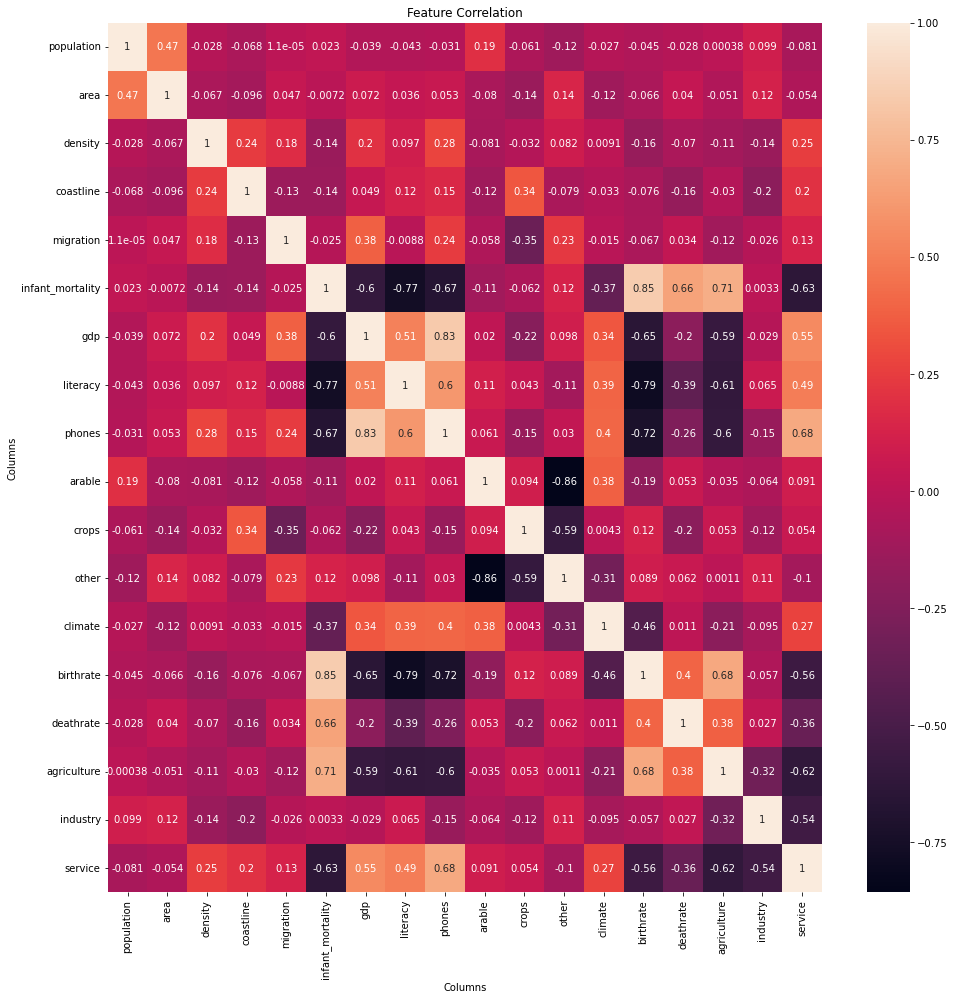

In [19]:
fig, ax = plt.subplots(figsize = (16,16))
sns.heatmap(data.corr(), annot =True, ax=ax).set(title = "Feature Correlation", xlabel = "Columns", ylabel = "Columns")

There are 5 feature that has high correlation with *GDP*. These are:

*   Phones (83%)
*   Service (55%)
*   Literacy (51%)
*   Migration (38%)
*   Climate (34%)



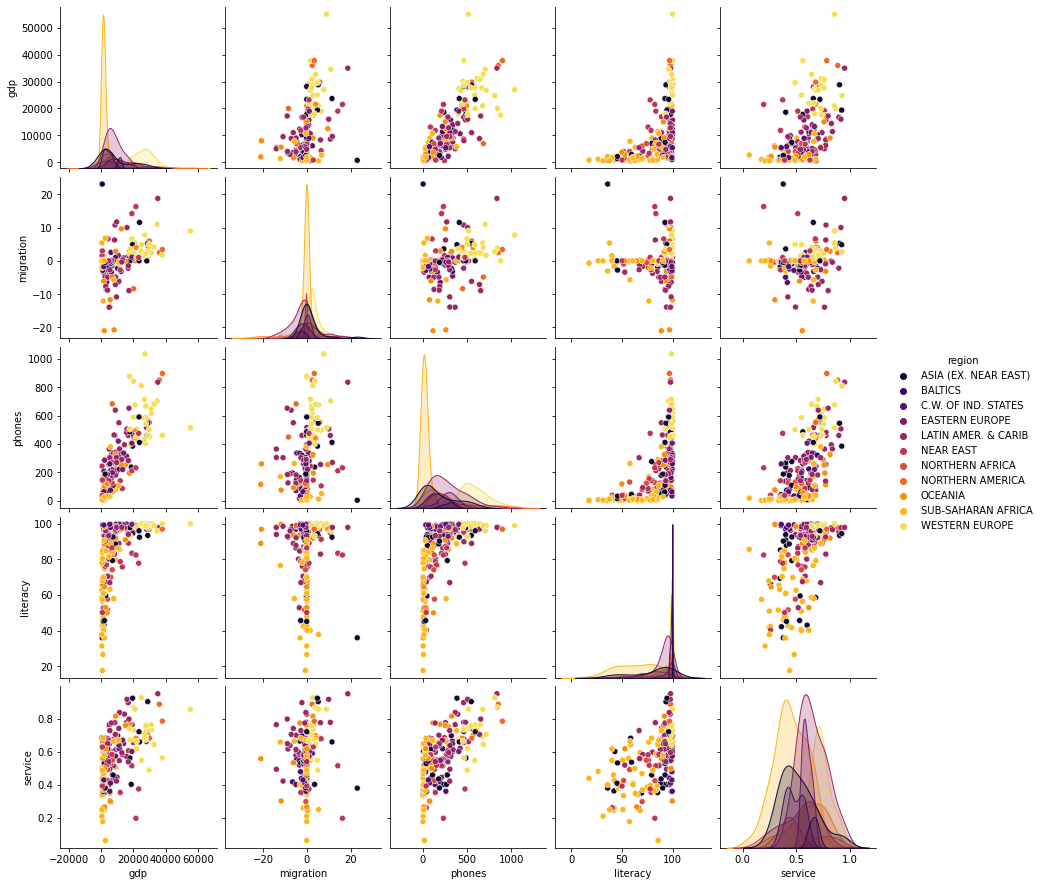

In [20]:
x = data.loc[:,["region","gdp","migration","phones","literacy","service"]]
sns.pairplot(x,hue="region",palette="inferno")

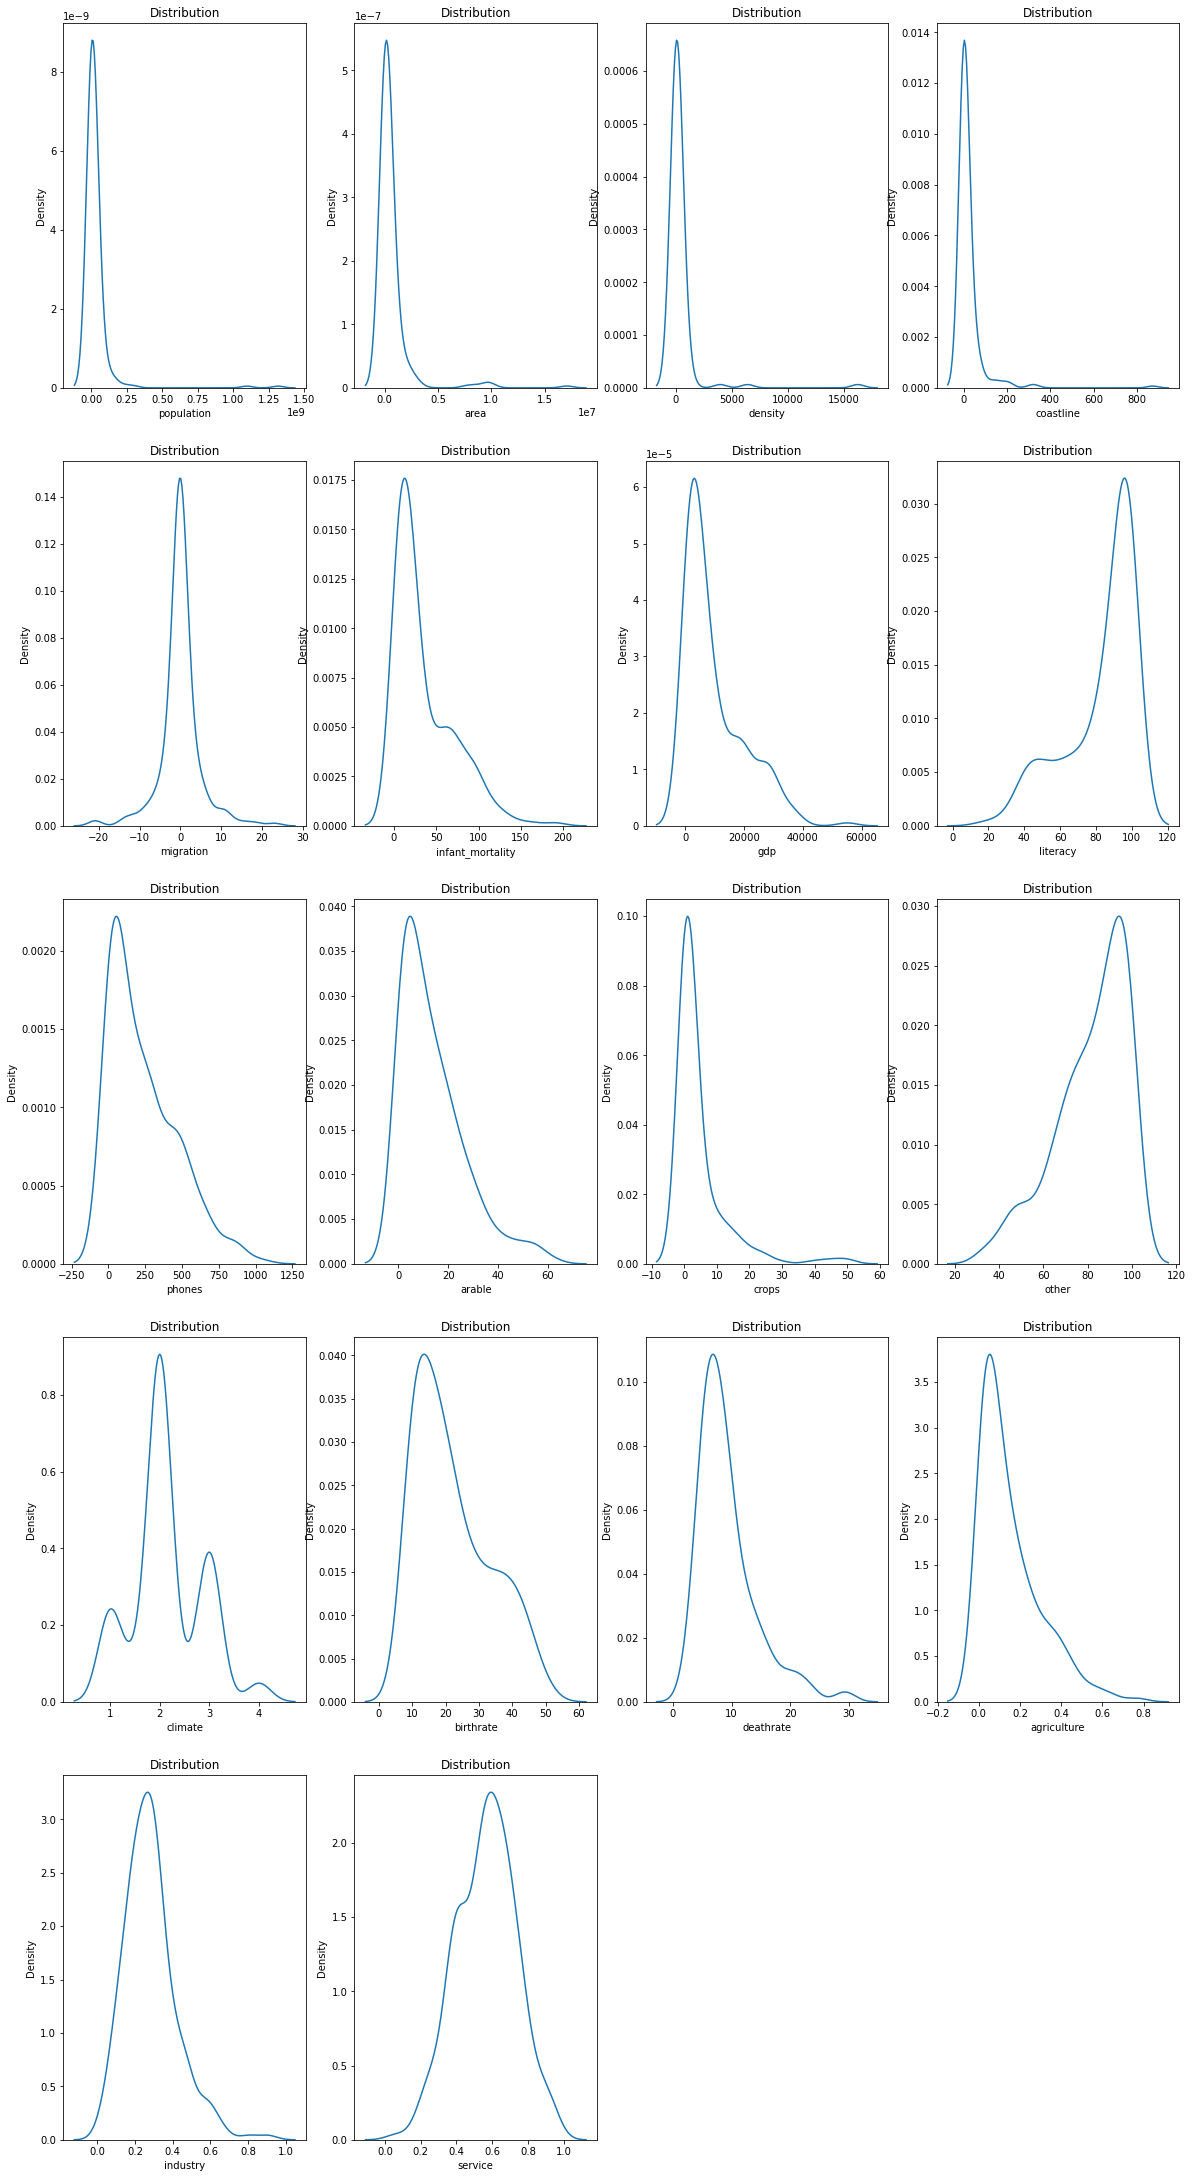

In [21]:
plt.figure(figsize=(20,47))
for i, column in enumerate(data.select_dtypes(include = ["int64", "float64"]).columns):
    axes = plt.subplot(6, 4, i+1)
    sns.kdeplot(data[column], ax=axes);
    plt.xlabel(column)
    plt.title("Distribution")
plt.show()

When we analyze the distribution of the data, we observe that certain variables exhibit a skewed distribution. However, upon closer examination of these skewed features, we discover that it is actually normal for them to have significantly varying values.

For example, some of the island countries like American Samoa has very small population but countries like India has high population.

We will use models specifically designed to handle skewed data, such as generalized linear models or tree-based models.

Text(0.5, 1.0, 'Number of Countries by REGION')

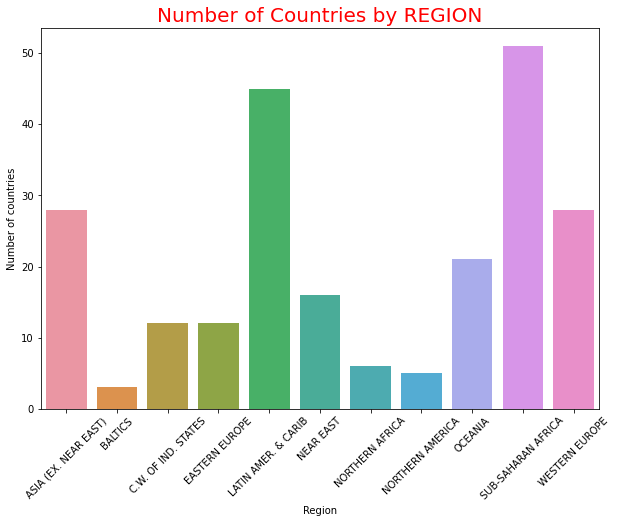

In [22]:
plt.figure(figsize=(10,7))
sns.barplot(x=data.region.value_counts().index, y=data.region.value_counts().values)
plt.xticks(rotation=45)
plt.ylabel('Number of countries')
plt.xlabel('Region')
plt.title('Number of Countries by REGION',color = 'red',fontsize=20)

# Data Preperation

Creating a data pipeline

In [23]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
])

In [24]:
categorical_columns = data.select_dtypes(include=['object', 'category']).columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns

numerical_columns = numerical_columns.drop("gdp")
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ],remainder = 'passthrough')

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)])

In [25]:
data['gdp'].fillna(2500, inplace=True)

The empty value in ***GDP*** is West Sahara, from internet search, its gdp is $2500.

In [26]:
X = data.drop(["gdp"], axis = 1)
y =data["gdp"]

X_preprocessed = pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Model Implementation

In [27]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'SVR': SVR(),
    'MLP': MLPRegressor()
}

param_grids = {
    'RandomForest': {
        'max_depth' : [3,5,10,15],
        'max_features': [0.7,1,0.5],
        'n_estimators': [100,300,500,700]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7, 9]
    },
    'SVR': {
        'C': [0.1, 0.2, 1, 10, 20],
        'kernel': ['linear', 'poly'],
        'gamma': [ 'scale', 'auto']
    },
    'MLP': {
        'alpha': [0.1, 0.01, 0.005],
        'hidden_layer_sizes':  [(32,64,128,64,32), (100,), (100,50), (32,64,32)],
        'activation': ["relu", "logistic"],
        'max_iter': [100,200,400,500]
    }
}

cv = KFold(n_splits=10, shuffle=True, random_state=42)


In [28]:
grids = {}
for model_name, model in models.items():
    #print(f'Training and tuning {model_name}...')
    grids[model_name] = GridSearchCV(estimator=model, param_grid= param_grids[model_name], cv=cv, n_jobs=-1)
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    r_squared = grids[model_name].best_score_
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best R-squared for {model_name}: {r_squared}\n')

Best parameters for RandomForest: {'max_depth': 5, 'max_features': 0.5, 'n_estimators': 300}
Best R-squared for RandomForest: 0.8157529552753173

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}
Best R-squared for XGBoost: 0.8086994925289268

Best parameters for SVR: {'C': 20, 'gamma': 'scale', 'kernel': 'linear'}
Best R-squared for SVR: 0.4775570896699275

Best parameters for MLP: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (32, 64, 128, 64, 32), 'max_iter': 400}
Best R-squared for MLP: 0.7503927195508002



# Creating models with the best parameters selected by GridSearchCV.

In [29]:
models = {
    'RandomForest': RandomForestRegressor(n_estimators= 500, max_features= 0.5, max_depth= 15, random_state=42),
    'XGBoost': XGBRegressor(n_estimators= 200, max_depth= 5, learning_rate= 0.1, random_state=42),
    'SVR': SVR(C= 20, gamma= 'scale', kernel= 'linear'),
    'MLP': MLPRegressor(activation= 'relu', alpha= 0.1, hidden_layer_sizes= (32, 64, 128, 64, 32), max_iter= 400)
}

In [30]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r_squared_score = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print(f'Best RMSE for {model_name}: {rmse}')
    print(f'Best R-squared for {model_name}: {r_squared_score}\n')

Best RMSE for RandomForest: 2726.5139743997756
Best R-squared for RandomForest: 0.9106027111172628

Best RMSE for XGBoost: 3647.829850582682
Best R-squared for XGBoost: 0.8399786101180398

Best RMSE for SVR: 6057.293447840404
Best R-squared for SVR: 0.5587688959823238

Best RMSE for MLP: 2440.929447738905
Best R-squared for MLP: 0.9283494800939068



# Conclusion

In this project, I used ***countries_of_the_world.csv*** dataset to predict **GDP** of each countries. I used 4 different model(Random Forest, XGBoost, SVR, MLP) and I achieved the best prediction performance using MLP.

The best prediction preformance was achieved using **MLP**, and resulted in the following metrics:

* Root Mean Squared Error **(RMSE)**: 2440.93
* R-squared Score **(R<sup>2</sup>)**: 0.928